# Scattering and profile as a function of energy

In order to define reasonable initial beam parameters, we need to know how much the beam is scattering at the Bragg peak, as a function of energy.
Furthermore, it would also be useful to compare the energy deposition and dose in the peak vs. in the entry.

This work is a pre-check for UiO Proton Therapy simulations with Geant4.

K. Sjobak, April 2020

## Code setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import ROOT
import os

Welcome to JupyROOT 6.21/01


In [2]:
#%matplotlib notebook #Doesn't work in JupyterLab, only Jupyter
%matplotlib inline

# plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 150
# 
# #colorCycle = plt.rcParams['axes.prop_cycle']
# plt.rcParams['figure.max_open_warning'] = 100

In [3]:
#Setup MiniScatter
import sys
MiniScatter_path="../build/."
sys.path.append(MiniScatter_path)
#import CLEARview

import miniScatterDriver
import miniScatterScanner
import miniScatterPlots

## Physics setup

In [4]:
# Used for normalization of the dose:
# need to scale with (number of actual particles) / (number of simulation particles)
SI_e = 1.60217662e-19 #[C]
beamCharge_total = 1e-9 # Beam charge [C]
beamCharge_numpart = beamCharge_total/SI_e

In [5]:
### Basic simulation parameters ###

QUIET = False
TRYLOAD = True #Try to load already existing data instead of recomputing?
NUM_THREADS = 10
TMPFOLDER = "/tmp/"+os.getlogin()+"/miniScatter/Pthera-EnergyScan"


baseSimSetup = {}
#baseSimSetup["PHYS"] = "QGSP_BERT__SS"
baseSimSetup["PHYS"] = "QGSP_BERT"
baseSimSetup["N"] = 10000
#baseSimSetup["N"] = 1000000

#EPS   = 3.0 #[um]
#BETA  = 1.4 #[m]
#ALPHA = 0.0
#baseSimSetup["COVAR"] = (EPS,BETA,ALPHA) #Use pencil beam

#baseSimSetup["ZOFFSET_BACKTRACK"] = True
baseSimSetup["ZOFFSET"]           = 0.0 #Auto

baseSimSetup["WORLDSIZE"] = 1000.0

baseSimSetup["DIST"] = 3000.0 #Detector distance from target center [mm] 

baseSimSetup["QUICKMODE"] = False #Include slow plots
baseSimSetup["MINIROOT"]  = True #Skip TTRees in the .root files
baseSimSetup["EDEP_DZ"]   = -1.0 #Negative: Only rz histograms

#Lowest energy particles to consider for analysis
#E_CUTOFF = baseSimSetup["ENERGY"]*0.9;

#Store the .root files in a subfolder from MiniScatter/examples, to be easy to find
baseSimSetup["OUTFOLDER"]=os.path.join(os.getcwd(),"outputs")
baseSimSetup["THICK"] = 1000 # More than sufficient for at least 200 MeV
baseSimSetup["MAT"] = "G4_WATER"

baseSimSetup["BEAM"] = "proton"


In [6]:
#Include to override TRYLOAD
TRYLOAD = False

## Test setup (200 MeV)

In [7]:
baseSimSetup_test200 = baseSimSetup.copy()
baseSimSetup_test200["ENERGY"] = 200.0 #[MeV]
baseSimSetup_test200["OUTNAME"]="test_200MeV"
baseSimSetup_test200["EDEP_DZ"] = abs(baseSimSetup_test200["EDEP_DZ"]) # Make the big 3D histo too

(twiss_test200, numPart_test200, objects_test200) = \
    miniScatterDriver.getData_tryLoad(baseSimSetup_test200, tryload=TRYLOAD,
                              getObjects=["targetEdep","target_edep_dens",'target_edep_rdens',"metadata"])

TryLoad is False, computing now.
Running command line: './MiniScatter -t 1000 -m G4_WATER -d 3000.0 -w 1000.0 -p QGSP_BERT -n 10000 -e 200.0 -b proton -z 0.0 -f test_200MeV -o /home/kyrsjo/code/MiniScatter/examples/outputs -r --edepDZ 1.0'
RunFolder = '/home/kyrsjo/code/MiniScatter/build'
logName   = '/home/kyrsjo/code/MiniScatter/examples/outputs/test_200MeV.txt'


/usr/lib64/python3.8/subprocess.py:844: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stdout = io.open(c2pread, 'rb', bufsize)


\
Event# 0
Event# 500
Event# 1000
Event# 1500
Event# 2000
Event# 2500
Event# 3000
Event# 3500
Event# 4000
Event# 4500
Event# 5000
Event# 5500
Event# 6000
Event# 6500
Event# 7000
Event# 7500
Event# 8000
Event# 8500
Event# 9000
Event# 9500
|
Done!
No particles found for det=tracker_cutoff
No particles found for det=target_cutoff


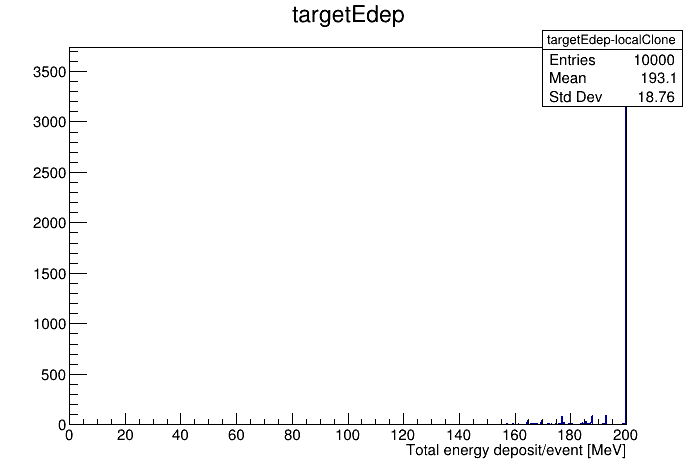

In [8]:
# %%capture

cc1 = ROOT.TCanvas()
objects_test200['targetEdep'].Draw()
cc1.Draw()

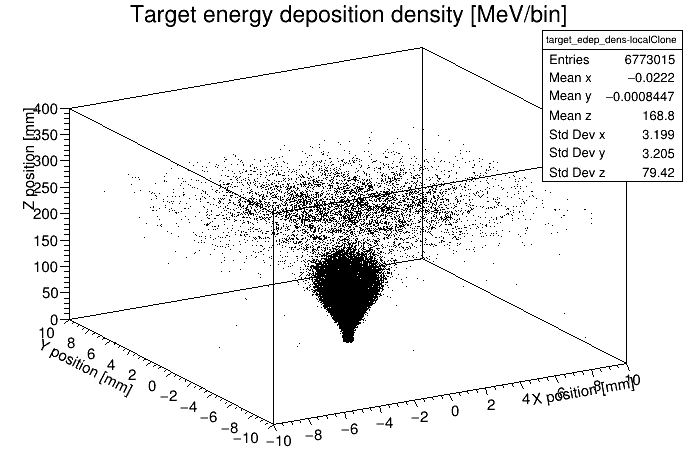

In [9]:
# %%capture

# Note: This one may look better with fewer events,
#       otherwise you just get a big blob in the center and no tracks.

cc2 = ROOT.TCanvas()
objects_test200['target_edep_dens'].GetZaxis().SetRangeUser(0,400)
objects_test200['target_edep_dens'].Draw()
cc2.Draw()

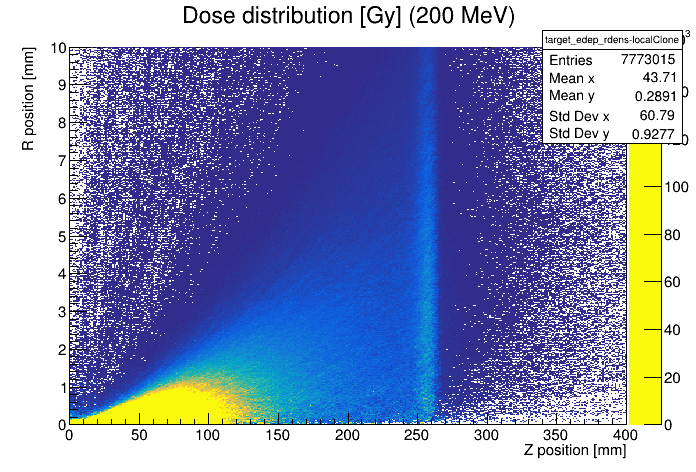

In [10]:
rzScaled_test200 = miniScatterPlots.plotRZgray(objects_test200, baseSimSetup_test200["N"], beamCharge_numpart)
canvas = ROOT.TCanvas()
rzScaled_test200.SetTitle(rzScaled_test200.GetTitle() + " (200 MeV)")
rzScaled_test200.SetContour(100, np.linspace(0,50,100))
rzScaled_test200.GetXaxis().SetRangeUser(0,400)
rzScaled_test200.GetYaxis().SetRangeUser(0,10)
rzScaled_test200.Draw('colz')
canvas.Draw()

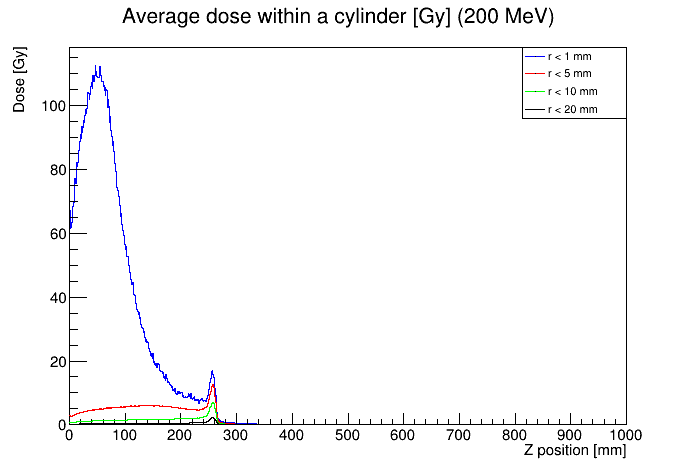

In [11]:
#%jsroot on
canvas = ROOT.TCanvas()

rzScaled_center_test200_1mm = miniScatterPlots.plotZgray(rzScaled_test200, 1)
rzScaled_center_test200_1mm.SetStats(False)
rzScaled_center_test200_1mm.SetName(rzScaled_center_test200_1mm.GetName() + "-1mm")
rzScaled_center_test200_1mm.SetTitle("Average dose within a cylinder [Gy] (200 MeV)")
rzScaled_center_test200_1mm.SetLineColor(ROOT.kBlue)
rzScaled_center_test200_1mm.Draw()

rzScaled_center_test200_5mm = miniScatterPlots.plotZgray(rzScaled_test200, 5)
rzScaled_center_test200_5mm.SetName(rzScaled_center_test200_5mm.GetName() + "-5mm")
rzScaled_center_test200_5mm.SetTitle("Average dose within a cylinder [Gy] (200 MeV)")
rzScaled_center_test200_5mm.SetLineColor(ROOT.kRed)
rzScaled_center_test200_5mm.Draw("same")

rzScaled_center_test200_10mm = miniScatterPlots.plotZgray(rzScaled_test200, 10)
rzScaled_center_test200_10mm.SetName(rzScaled_center_test200_10mm.GetName() + "-5mm")
rzScaled_center_test200_10mm.SetTitle("Average dose within a cylinder [Gy] (200 MeV)")
rzScaled_center_test200_10mm.SetLineColor(ROOT.kGreen)
rzScaled_center_test200_10mm.Draw("same")

rzScaled_center_test200_20mm = miniScatterPlots.plotZgray(rzScaled_test200, 20)
rzScaled_center_test200_20mm.SetName(rzScaled_center_test200_20mm.GetName() + "-5mm")
rzScaled_center_test200_20mm.SetTitle("Average dose within a cylinder [Gy] (200 MeV)")
rzScaled_center_test200_20mm.SetLineColor(ROOT.kBlack)
rzScaled_center_test200_20mm.Draw("same")

rzScaled_center_test200_legend = ROOT.TLegend(0.75,0.75,0.9,0.9);
rzScaled_center_test200_legend.AddEntry(rzScaled_center_test200_1mm,"r < 1 mm")
rzScaled_center_test200_legend.AddEntry(rzScaled_center_test200_5mm,"r < 5 mm")
rzScaled_center_test200_legend.AddEntry(rzScaled_center_test200_10mm,"r < 10 mm")
rzScaled_center_test200_legend.AddEntry(rzScaled_center_test200_20mm,"r < 20 mm")
rzScaled_center_test200_legend.Draw()

canvas.Draw()
#%jsroot off

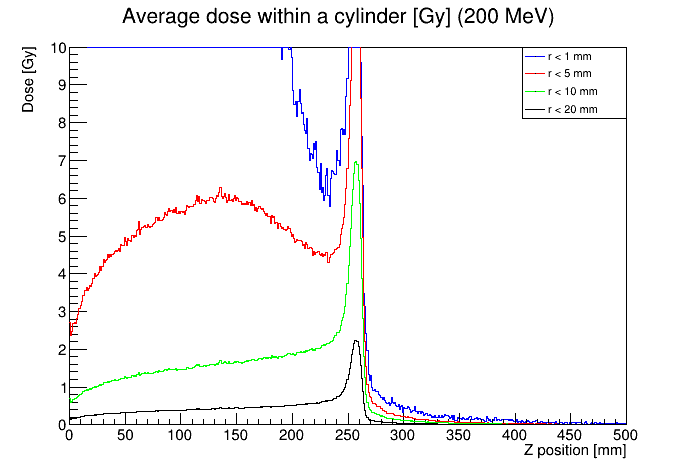

In [12]:
rzScaled_center_test200_1mm.GetXaxis().SetRangeUser(0,500)
rzScaled_center_test200_1mm.GetYaxis().SetRangeUser(0,10)
canvas.Draw()

## Test setup (100 MeV)

In [13]:
baseSimSetup_test100 = baseSimSetup.copy()
baseSimSetup_test100["ENERGY"] = 100.0 #[MeV]
baseSimSetup_test100["OUTNAME"]="test_100MeV"

baseSimSetup_test100["THICK"]   = 500
baseSimSetup_test100["EDEP_DZ"] = -0.5
baseSimSetup_test100["EDEP_DZ"] = abs(baseSimSetup_test100["EDEP_DZ"]) # Make the big 3D histo too

(twiss_test100, numPart_test100, objects_test100) = \
    miniScatterDriver.getData_tryLoad(baseSimSetup_test100, tryload=TRYLOAD,
                              getObjects=["targetEdep","target_edep_dens",'target_edep_rdens',"metadata"])

TryLoad is False, computing now.
Running command line: './MiniScatter -t 500 -m G4_WATER -d 3000.0 -w 1000.0 -p QGSP_BERT -n 10000 -e 100.0 -b proton -z 0.0 -f test_100MeV -o /home/kyrsjo/MiniScatter-work/test_energyScatter/outputs -r --edepDZ 0.5'
RunFolder = '/home/kyrsjo/code/MiniScatter/build'
logName   = '/home/kyrsjo/MiniScatter-work/test_energyScatter/outputs/test_100MeV.txt'
\
Event# 0
Event# 500
Event# 1000
Event# 1500
Event# 2000
Event# 2500
Event# 3000
Event# 3500
Event# 4000
Event# 4500
Event# 5000
Event# 5500
Event# 6000
Event# 6500
Event# 7000
Event# 7500
Event# 8000
Event# 8500
Event# 9000
Event# 9500
|
Done!
No particles found for det=tracker_cutoff
No particles found for det=target_cutoff


In [14]:
%%capture

cc1 = ROOT.TCanvas()
objects_test100['targetEdep'].Draw()
cc1.Draw()

In [15]:
%%capture

# Note: This one may look better with fewer events,
#       otherwise you just get a big blob in the center and no tracks.

cc2 = ROOT.TCanvas()
objects_test100['target_edep_dens'].GetZaxis().SetRangeUser(0,200)
objects_test100['target_edep_dens'].Draw()
cc2.Draw()

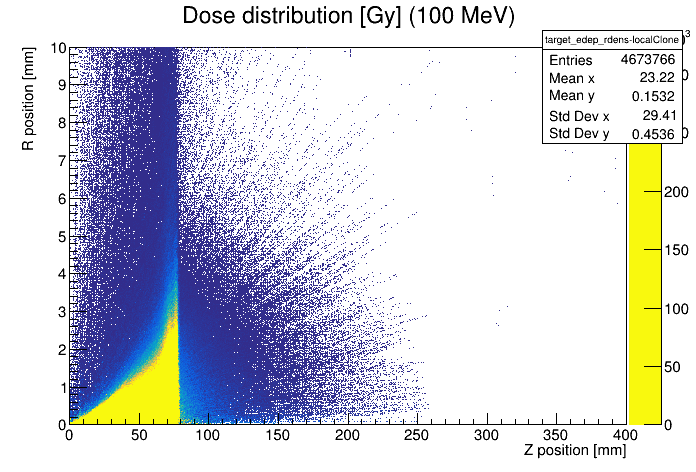

In [16]:
rzScaled_test100 = miniScatterPlots.plotRZgray(objects_test100, baseSimSetup_test100["N"], beamCharge_numpart)
canvas = ROOT.TCanvas()
rzScaled_test100.SetTitle(rzScaled_test100.GetTitle() + " (100 MeV)")
rzScaled_test100.SetContour(100, np.linspace(0,50,100))
rzScaled_test100.GetXaxis().SetRangeUser(0,400)
rzScaled_test100.GetYaxis().SetRangeUser(0,10)
rzScaled_test100.Draw('colz')
canvas.Draw()

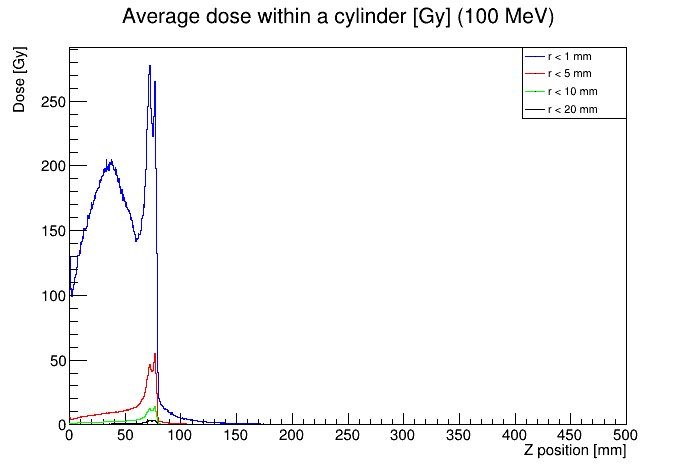

In [17]:
#%jsroot on
canvas = ROOT.TCanvas()

rzScaled_center_test100_1mm = miniScatterPlots.plotZgray(rzScaled_test100, 1)
rzScaled_center_test100_1mm.SetStats(False)
rzScaled_center_test100_1mm.SetName(rzScaled_center_test100_1mm.GetName() + "-1mm")
rzScaled_center_test100_1mm.SetTitle("Average dose within a cylinder [Gy] (100 MeV)")
rzScaled_center_test100_1mm.SetLineColor(ROOT.kBlue)
rzScaled_center_test100_1mm.Draw()

rzScaled_center_test100_5mm = miniScatterPlots.plotZgray(rzScaled_test100, 5)
rzScaled_center_test100_5mm.SetName(rzScaled_center_test100_5mm.GetName() + "-5mm")
rzScaled_center_test100_5mm.SetTitle("Average dose within a cylinder [Gy] (100 MeV)")
rzScaled_center_test100_5mm.SetLineColor(ROOT.kRed)
rzScaled_center_test100_5mm.Draw("same")

rzScaled_center_test100_10mm = miniScatterPlots.plotZgray(rzScaled_test100, 10)
rzScaled_center_test100_10mm.SetName(rzScaled_center_test100_10mm.GetName() + "-5mm")
rzScaled_center_test100_10mm.SetTitle("Average dose within a cylinder [Gy] (100 MeV)")
rzScaled_center_test100_10mm.SetLineColor(ROOT.kGreen)
rzScaled_center_test100_10mm.Draw("same")

rzScaled_center_test100_20mm = miniScatterPlots.plotZgray(rzScaled_test100, 20)
rzScaled_center_test100_20mm.SetName(rzScaled_center_test100_20mm.GetName() + "-5mm")
rzScaled_center_test100_20mm.SetTitle("Average dose within a cylinder [Gy] (100 MeV)")
rzScaled_center_test100_20mm.SetLineColor(ROOT.kBlack)
rzScaled_center_test100_20mm.Draw("same")

rzScaled_center_test100_legend = ROOT.TLegend(0.75,0.75,0.9,0.9);
rzScaled_center_test100_legend.AddEntry(rzScaled_center_test100_1mm,"r < 1 mm")
rzScaled_center_test100_legend.AddEntry(rzScaled_center_test100_5mm,"r < 5 mm")
rzScaled_center_test100_legend.AddEntry(rzScaled_center_test100_10mm,"r < 10 mm")
rzScaled_center_test100_legend.AddEntry(rzScaled_center_test100_20mm,"r < 20 mm")
rzScaled_center_test100_legend.Draw()

canvas.Draw()
#%jsroot off

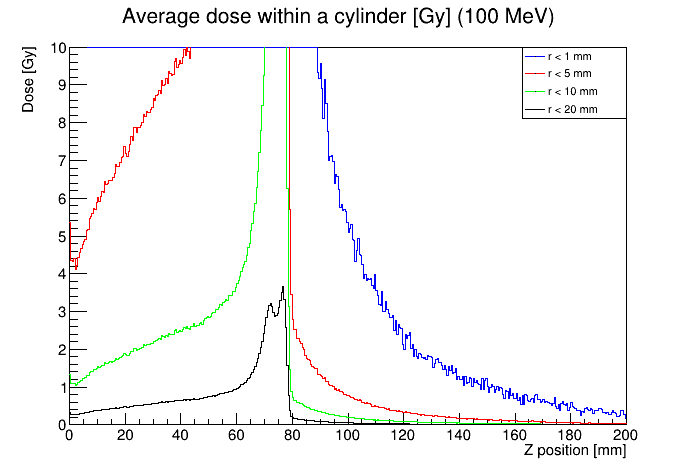

In [18]:
rzScaled_center_test100_1mm.GetXaxis().SetRangeUser(0,200)
rzScaled_center_test100_1mm.GetYaxis().SetRangeUser(0,10)
canvas.Draw()

## Test setup (50 MeV)

In [19]:
baseSimSetup_test50 = baseSimSetup.copy()
baseSimSetup_test50["ENERGY"] = 50.0 #[MeV]
baseSimSetup_test50["OUTNAME"]="test_50MeV"

baseSimSetup_test50["THICK"]   = 100
baseSimSetup_test50["EDEP_DZ"] = -0.1
baseSimSetup_test50["EDEP_DZ"] = abs(baseSimSetup_test50["EDEP_DZ"]) # Make the big 3D histo too
baseSimSetup_test50["PHYS_CUTDIST"] = 0.01

(twiss_test50, numPart_test50, objects_test50) = \
    miniScatterDriver.getData_tryLoad(baseSimSetup_test50, tryload=TRYLOAD,
                              getObjects=["targetEdep","target_edep_dens",'target_edep_rdens',"metadata"])

TryLoad is False, computing now.
Running command line: './MiniScatter -t 100 -m G4_WATER -d 3000.0 -w 1000.0 -p QGSP_BERT --physCutoffDist 0.01 -n 10000 -e 50.0 -b proton -z 0.0 -f test_50MeV -o /home/kyrsjo/MiniScatter-work/test_energyScatter/outputs -r --edepDZ 0.1'
RunFolder = '/home/kyrsjo/code/MiniScatter/build'
logName   = '/home/kyrsjo/MiniScatter-work/test_energyScatter/outputs/test_50MeV.txt'
\
Event# 0
Event# 500
Event# 1000
Event# 1500
Event# 2000
Event# 2500
Event# 3000
Event# 3500
Event# 4000
Event# 4500
Event# 5000
Event# 5500
Event# 6000
Event# 6500
Event# 7000
Event# 7500
Event# 8000
Event# 8500
Event# 9000
Event# 9500
\
Done!
No particles found for det=tracker_cutoff
No particles found for det=target_cutoff


In [20]:
%%capture

cc1 = ROOT.TCanvas()
objects_test50['targetEdep'].Draw()
cc1.Draw()

In [21]:
%%capture

# Note: This one may look better with fewer events,
#       otherwise you just get a big blob in the center and no tracks.

cc2 = ROOT.TCanvas()
objects_test50['target_edep_dens'].GetZaxis().SetRangeUser(0,200)
objects_test50['target_edep_dens'].Draw()
cc2.Draw()

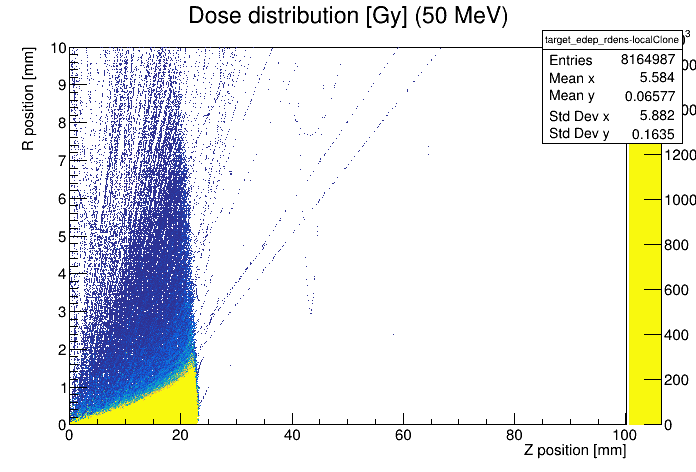

In [22]:
rzScaled_test50 = miniScatterPlots.plotRZgray(objects_test50, baseSimSetup_test50["N"], beamCharge_numpart)
canvas = ROOT.TCanvas()
rzScaled_test50.SetTitle(rzScaled_test50.GetTitle() + " (50 MeV)")
rzScaled_test50.SetContour(50, np.linspace(0,50,50))
rzScaled_test50.GetXaxis().SetRangeUser(0,400)
rzScaled_test50.GetYaxis().SetRangeUser(0,10)
rzScaled_test50.Draw('colz')
canvas.Draw()

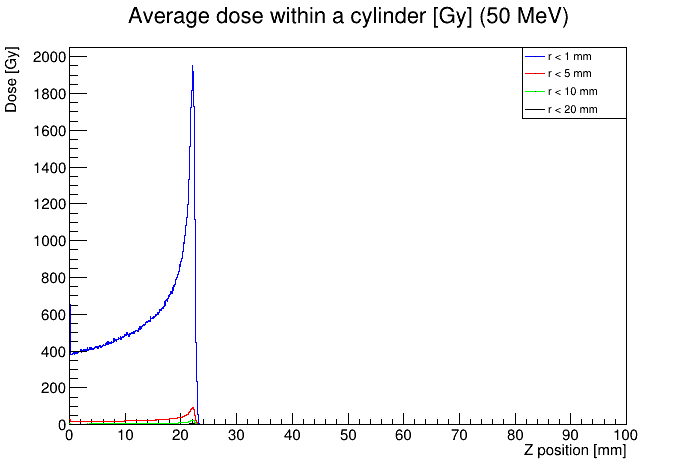

In [23]:
#%jsroot on
canvas = ROOT.TCanvas()

rzScaled_center_test50_1mm = miniScatterPlots.plotZgray(rzScaled_test50, 1)
rzScaled_center_test50_1mm.SetStats(False)
rzScaled_center_test50_1mm.SetName(rzScaled_center_test50_1mm.GetName() + "-1mm")
rzScaled_center_test50_1mm.SetTitle("Average dose within a cylinder [Gy] (50 MeV)")
rzScaled_center_test50_1mm.SetLineColor(ROOT.kBlue)
rzScaled_center_test50_1mm.Draw()

rzScaled_center_test50_5mm = miniScatterPlots.plotZgray(rzScaled_test50, 5)
rzScaled_center_test50_5mm.SetName(rzScaled_center_test50_5mm.GetName() + "-5mm")
rzScaled_center_test50_5mm.SetTitle("Average dose within a cylinder [Gy] (50 MeV)")
rzScaled_center_test50_5mm.SetLineColor(ROOT.kRed)
rzScaled_center_test50_5mm.Draw("same")

rzScaled_center_test50_10mm = miniScatterPlots.plotZgray(rzScaled_test50, 10)
rzScaled_center_test50_10mm.SetName(rzScaled_center_test50_10mm.GetName() + "-5mm")
rzScaled_center_test50_10mm.SetTitle("Average dose within a cylinder [Gy] (50 MeV)")
rzScaled_center_test50_10mm.SetLineColor(ROOT.kGreen)
rzScaled_center_test50_10mm.Draw("same")

rzScaled_center_test50_20mm = miniScatterPlots.plotZgray(rzScaled_test50, 20)
rzScaled_center_test50_20mm.SetName(rzScaled_center_test50_20mm.GetName() + "-5mm")
rzScaled_center_test50_20mm.SetTitle("Average dose within a cylinder [Gy] (50 MeV)")
rzScaled_center_test50_20mm.SetLineColor(ROOT.kBlack)
rzScaled_center_test50_20mm.Draw("same")

rzScaled_center_test50_legend = ROOT.TLegend(0.75,0.75,0.9,0.9);
rzScaled_center_test50_legend.AddEntry(rzScaled_center_test50_1mm,"r < 1 mm")
rzScaled_center_test50_legend.AddEntry(rzScaled_center_test50_5mm,"r < 5 mm")
rzScaled_center_test50_legend.AddEntry(rzScaled_center_test50_10mm,"r < 10 mm")
rzScaled_center_test50_legend.AddEntry(rzScaled_center_test50_20mm,"r < 20 mm")
rzScaled_center_test50_legend.Draw()

canvas.Draw()
#%jsroot off

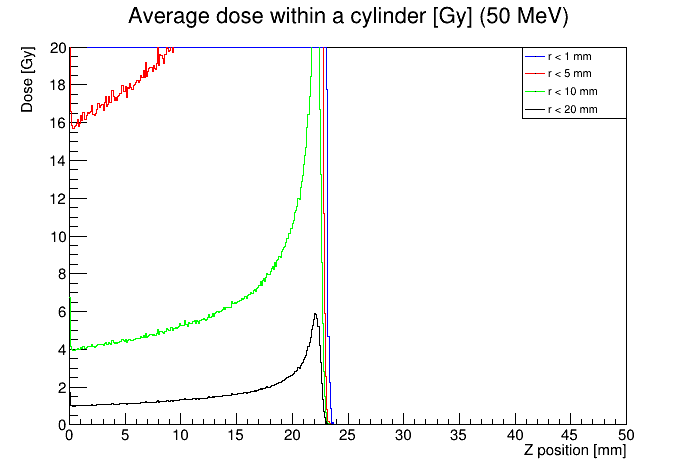

In [24]:
rzScaled_center_test50_1mm.GetXaxis().SetRangeUser(0,50)
rzScaled_center_test50_1mm.GetYaxis().SetRangeUser(0,20)
canvas.Draw()

## Test setup (10 MeV)

In [25]:
baseSimSetup_test10 = baseSimSetup.copy()
baseSimSetup_test10["ENERGY"] = 10.0 #[MeV]
baseSimSetup_test10["OUTNAME"]="test_10MeV"

baseSimSetup_test10["THICK"]   = 10
baseSimSetup_test10["EDEP_DZ"] = -0.01
baseSimSetup_test10["EDEP_DZ"] = abs(baseSimSetup_test10["EDEP_DZ"]) # Make the big 3D histo too
baseSimSetup_test10["PHYS_CUTDIST"] = 0.001

(twiss_test10, numPart_test10, objects_test10) = \
    miniScatterDriver.getData_tryLoad(baseSimSetup_test10, tryload=TRYLOAD,
                              getObjects=["targetEdep","target_edep_dens",'target_edep_rdens',"metadata"])

TryLoad is False, computing now.
Running command line: './MiniScatter -t 10 -m G4_WATER -d 3000.0 -w 1000.0 -p QGSP_BERT --physCutoffDist 0.001 -n 10000 -e 10.0 -b proton -z 0.0 -f test_10MeV -o /home/kyrsjo/MiniScatter-work/test_energyScatter/outputs -r --edepDZ 0.01'
RunFolder = '/home/kyrsjo/code/MiniScatter/build'
logName   = '/home/kyrsjo/MiniScatter-work/test_energyScatter/outputs/test_10MeV.txt'
\
Event# 0
Event# 500
Event# 1000
Event# 1500
Event# 2000
Event# 2500
Event# 3000
Event# 3500
Event# 4000
Event# 4500
Event# 5000
Event# 5500
Event# 6000
Event# 6500
Event# 7000
Event# 7500
Event# 8000
Event# 8500
Event# 9000
Event# 9500
|
Done!
No particles found for det=tracker
No particles found for det=tracker_cutoff
No particles found for det=target_cutoff


In [26]:
%%capture

cc1 = ROOT.TCanvas()
objects_test10['targetEdep'].Draw()
cc1.Draw()

In [27]:
%%capture

# Note: This one may look better with fewer events,
#       otherwise you just get a big blob in the center and no tracks.

cc2 = ROOT.TCanvas()
objects_test10['target_edep_dens'].GetZaxis().SetRangeUser(0,200)
objects_test10['target_edep_dens'].Draw()
cc2.Draw()

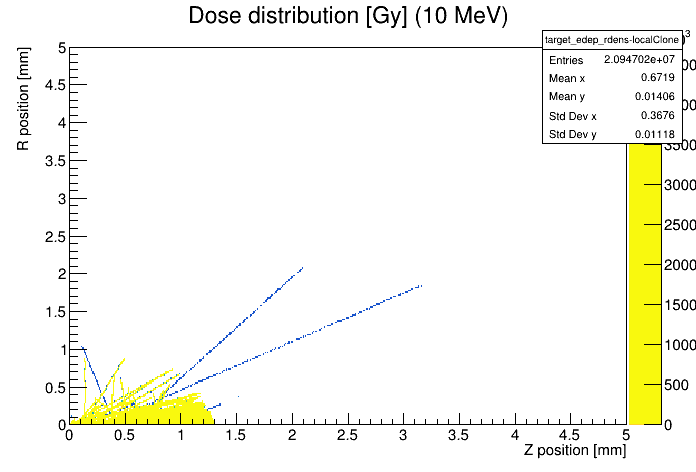

In [28]:
rzScaled_test10 = miniScatterPlots.plotRZgray(objects_test10, baseSimSetup_test10["N"], beamCharge_numpart)
canvas = ROOT.TCanvas()
rzScaled_test10.SetTitle(rzScaled_test10.GetTitle() + " (10 MeV)")
rzScaled_test10.SetContour(10, np.linspace(0,10,10))
rzScaled_test10.GetXaxis().SetRangeUser(0,5)
rzScaled_test10.GetYaxis().SetRangeUser(0,5)
rzScaled_test10.Draw('colz')
canvas.Draw()

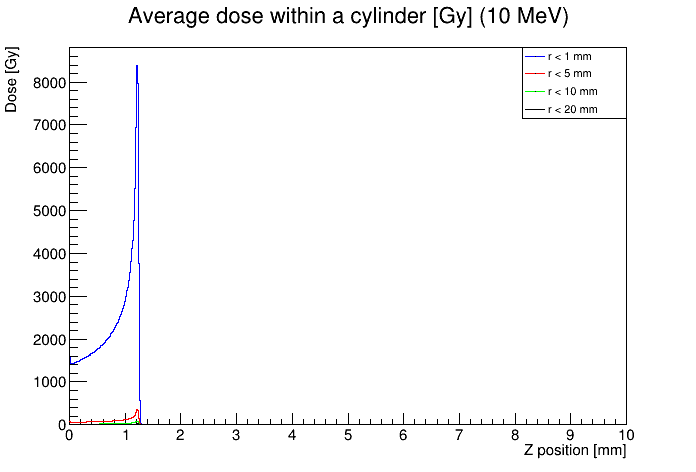

In [29]:
#%jsroot on
canvas = ROOT.TCanvas()

rzScaled_center_test10_1mm = miniScatterPlots.plotZgray(rzScaled_test10, 1)
rzScaled_center_test10_1mm.SetStats(False)
rzScaled_center_test10_1mm.SetName(rzScaled_center_test10_1mm.GetName() + "-1mm")
rzScaled_center_test10_1mm.SetTitle("Average dose within a cylinder [Gy] (10 MeV)")
rzScaled_center_test10_1mm.SetLineColor(ROOT.kBlue)
rzScaled_center_test10_1mm.Draw()

rzScaled_center_test10_5mm = miniScatterPlots.plotZgray(rzScaled_test10, 5)
rzScaled_center_test10_5mm.SetName(rzScaled_center_test10_5mm.GetName() + "-5mm")
rzScaled_center_test10_5mm.SetTitle("Average dose within a cylinder [Gy] (10 MeV)")
rzScaled_center_test10_5mm.SetLineColor(ROOT.kRed)
rzScaled_center_test10_5mm.Draw("same")

rzScaled_center_test10_10mm = miniScatterPlots.plotZgray(rzScaled_test10, 10)
rzScaled_center_test10_10mm.SetName(rzScaled_center_test10_10mm.GetName() + "-5mm")
rzScaled_center_test10_10mm.SetTitle("Average dose within a cylinder [Gy] (10 MeV)")
rzScaled_center_test10_10mm.SetLineColor(ROOT.kGreen)
rzScaled_center_test10_10mm.Draw("same")

rzScaled_center_test10_20mm = miniScatterPlots.plotZgray(rzScaled_test10, 20)
rzScaled_center_test10_20mm.SetName(rzScaled_center_test10_20mm.GetName() + "-5mm")
rzScaled_center_test10_20mm.SetTitle("Average dose within a cylinder [Gy] (10 MeV)")
rzScaled_center_test10_20mm.SetLineColor(ROOT.kBlack)
rzScaled_center_test10_20mm.Draw("same")

rzScaled_center_test10_legend = ROOT.TLegend(0.75,0.75,0.9,0.9);
rzScaled_center_test10_legend.AddEntry(rzScaled_center_test10_1mm,"r < 1 mm")
rzScaled_center_test10_legend.AddEntry(rzScaled_center_test10_5mm,"r < 5 mm")
rzScaled_center_test10_legend.AddEntry(rzScaled_center_test10_10mm,"r < 10 mm")
rzScaled_center_test10_legend.AddEntry(rzScaled_center_test10_20mm,"r < 20 mm")
rzScaled_center_test10_legend.Draw()

canvas.Draw()
#%jsroot off

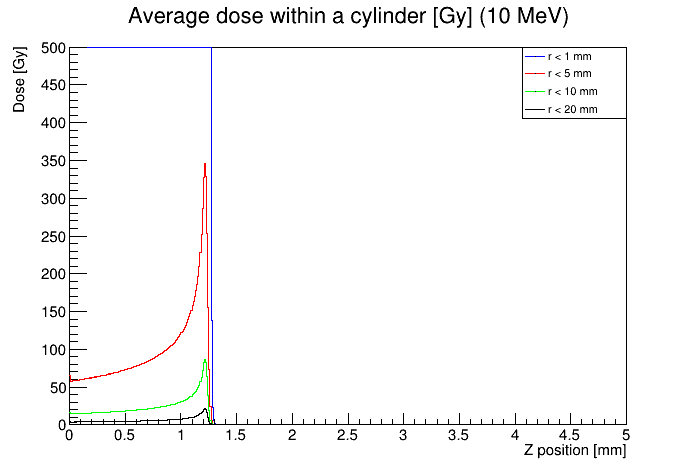

In [30]:
rzScaled_center_test10_1mm.GetXaxis().SetRangeUser(0,5)
rzScaled_center_test10_1mm.GetYaxis().SetRangeUser(0,500)
canvas.Draw()

# Analysis test

Here we want to
1. Roughly find the Bragg peak, and define a window on which to fit it
2. Fit the peak -> longitudinal position and width
3. Compute the total energy deposit and dose balance balance peak/plateau
4. Extract a a transverse slice of the window & plot (as function of r/z, r, and x/y -- remember Jacobian when converting to x/y!) fit the plateau width.

This should all be done starting with a 2D r/z plot. Then we use miniScatterPlots.plotZgray with a wide rMax to do the peak finding etc; finally we extract a slice of the original 2D plot and project onto the r axis to remove the z.

Finally we do the analysis on a energy scan, plotting as a function of beam energy:
1. Peak depth
2. Peak width
3. Peak transverse width (scattering)

This should all be wrapped up in a nice little python function.

CHECK: Are we defining initial beam momentum (MeV/c), kinetic energy, or total energy (including rest mass)?

import And then we are ready to implement the shield mask etc.

In [31]:
def braggPeakAnalysis(rzScaledHisto, rMax=10.0, startThresh=0.5, endThresh=0.1):
    
    #Find and fit the Bragg peak
    rzScaledHisto_center = miniScatterPlots.plotZgray(rzScaledHisto, 10)
    (iMin, iMax, zFit) = braggPeakFinderFitter(rzScaledHisto_center, startThresh, endThresh)
    
    nBins  = rzScaledHisto_center.GetNbinsX()
    zMin   = rzScaledHisto_center.GetBinLowEdge(iMin)    # [mm]
    zMax   = rzScaledHisto_center.GetBinLowEdge(iMax+1)  # [mm]
    zTotal = rzScaledHisto_center.GetBinLowEdge(nBins+1) # [mm]
    
    #Extract data about energy deposits
    plateauEnergy = rzScaledHisto_center.Integral(1,      iMin-1, "width" )
    peakEnergy    = rzScaledHisto_center.Integral(iMin,   iMax,   "width" )
    afterEnergy   = rzScaledHisto_center.Integral(iMax+1, nBins,  "width" )
    print("Avg. dose*L for plateau/peak/after: {:.1f}, {:.1f} {:.1f} [Gy*mm], proportional to energy deposit in region".\
          format(plateauEnergy, peakEnergy, afterEnergy) )
    print("Avg. dose for plateau/peak/after:   {:.1f}, {:.1f} {:.1f} [Gy], proportional to -dE/dz".\
          format(plateauEnergy / zMin, \
                 peakEnergy    / (zMax-zMin), \
                 afterEnergy   / (zTotal-zMax) ) )
    
    #Peak transverse width due to scattering
    rzScaledHisto_rPeak = plotRgray(rzScaledHisto,iMin,iMax)
    
    return (rzScaledHisto_center, iMin, iMax, zFit, rzScaledHisto_rPeak)

def plotRgray(rzHist_Gy, idx_zMin,idx_zMax):
    """
    Get a slice from zMin to zMax, given as indexes into the histogram X axis (z [mm]),
    project onto histogram Y axis (r [mm]) and normalize.
    
    Input: rz 2D histogram of dose in Gy [= edep/(volume*mass density)],
    so the radial dependence is already taken care of.
    """
    
    #Reset scaling and check that the scaling we're attempting is on a bin edge
    firstX_old = rzHist_Gy.GetXaxis().GetFirst()
    lastX_old  = rzHist_Gy.GetXaxis().GetLast()

    firstY_old = rzHist_Gy.GetYaxis().GetFirst()
    lastY_old  = rzHist_Gy.GetYaxis().GetLast()

    #rzHist_Gy.GetXaxis().SetRange(idx_zMin,idx_zMax)
    rzHist_Gy.GetXaxis().SetRange(0,rzHist_Gy.GetXaxis().GetNbins())
    rzHist_Gy.GetYaxis().SetRange(0,rzHist_Gy.GetYaxis().GetNbins())

    zMin = rzHist_Gy.GetXaxis().GetBinLowEdge(idx_zMin)
    zMax = rzHist_Gy.GetXaxis().GetBinLowEdge(idx_zMax)
    
    rHist = rzHist_Gy.ProjectionY(rzHist_Gy.GetName()+"_rSlice_{:d}-{:d}".format(idx_zMin,idx_zMax),\
                                  idx_zMin, idx_zMax)
    rHist.Scale(1/(zMax-zMin))
    
    #Restore the range settings of the 2D histogram
    rzHist_Gy.GetXaxis().SetRange(firstX_old, lastX_old)
    rzHist_Gy.GetYaxis().SetRange(firstY_old, lastY_old)

    rHist.SetTitle("Average dose [Gy] within {:.2f} < z < {:.2f} [mm]".format(zMin,zMax))
    rHist.SetXTitle(rzHist_Gy.GetYaxis().GetTitle())
    rHist.SetYTitle("Dose [Gy]")

    return rHist


def braggPeakFinderFitter(zScaledHisto, startThresh=0.5, endThresh=0.1):
    "Do step 1-3 of the analysis"
    
    #Find the peak; if the scaled histo is wide enough this should be the peak of the Bragg Peak
    nBins  = zScaledHisto.GetNbinsX()
    maxBin = zScaledHisto.GetMaximumBin()
    maxBinContent = zScaledHisto.GetBinContent(maxBin)
    
    #Search upwards for the end of the peak window
    iMax = None
    for i in range(maxBin,nBins+1):
        bc = zScaledHisto.GetBinContent(i)
        if bc < endThresh*maxBinContent:
            iMax = i;
            break
    if iMax is None:
        raise ValueError("Histogram too short after peak while searching for peak window.")

    #Search downwards for the beginning of the peak window
    iMin = None
    for i in range(maxBin,0,-1):
        bc = zScaledHisto.GetBinContent(i)
        if bc < startThresh*maxBinContent:
            iMin = i;
            break
    if iMin is None:
        raise ValueError("Histogram too short before peak while searching for peak window.")
        
    #Fit
    fit = zScaledHisto.Fit("gaus","SQ","",zScaledHisto.GetBinCenter(iMin), zScaledHisto.GetBinCenter(iMax))
    return (iMin, iMax, fit)


In [32]:
%%capture
## Test the braggPeakFinderFitter function by itself

braggPeakFinderFitter(rzScaled_center_test200_10mm)

canvas = ROOT.TCanvas()
rzScaled_center_test200_10mm.Draw()
rzScaled_center_test200_10mm.GetXaxis().SetRangeUser(0,400)
canvas.Draw()



In [33]:
#Test the braggPeakAnalysis function.
# By default it uses an r=10mm integration window
# Plots are in later cells

rz200 = braggPeakAnalysis(rzScaled_test200)
#print(rz200)
#print()

Avg. dose*L for plateau/peak/after: 388.6, 89.3 13.5 [Gy*mm], proportional to energy deposit in region
Avg. dose for plateau/peak/after:   1.6, 4.5 0.0 [Gy], proportional to -dE/dz


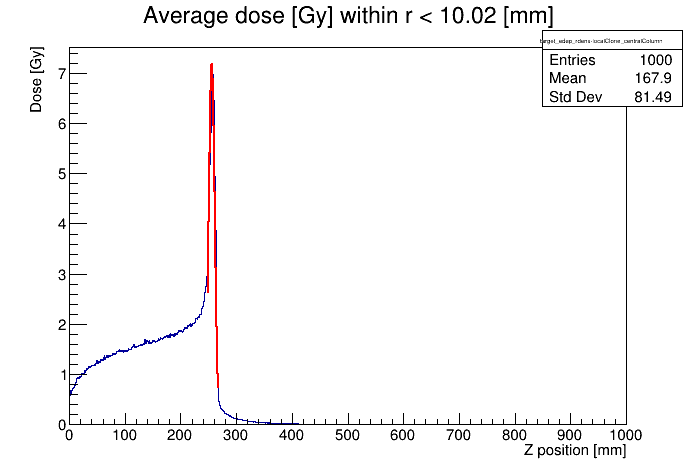

In [34]:
#Plot1
canvas = ROOT.TCanvas()
rz200[0].Draw()
canvas.Draw()

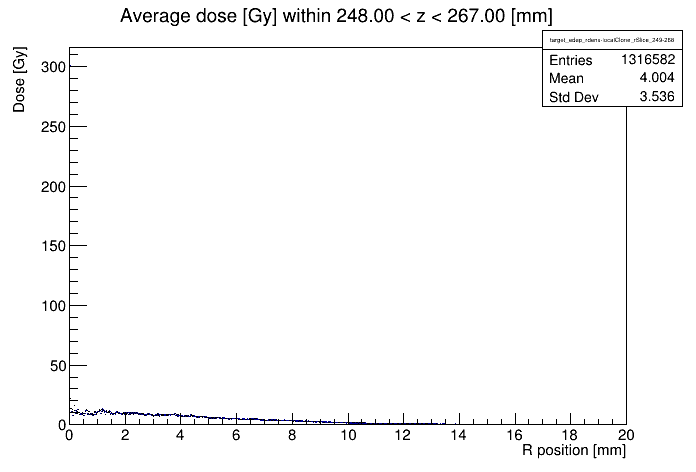

In [35]:
#Plot2
canvas = ROOT.TCanvas()
#rz200[4].GetXaxis().SetRangeUser(0,0.5)
rz200[4].Draw()
canvas.Draw()

In [36]:
# Notice huge peak at zero-bin; how much of the energy does this really account for?
# Remember that the outer bins have much more volume

rDose = []
for i in range(1,rz200[4].GetXaxis().GetNbins()+1):
    rMin = rz200[4].GetXaxis().GetBinLowEdge(i)
    rMax = rz200[4].GetXaxis().GetBinLowEdge(i+1)
    area = np.pi*(rMax**2-rMin**2)
    
    rDose.append(rz200[4].GetBinContent(i)*area)

print (rz200[4].Integral(1,1))

rDose = np.asarray(rDose)
print(rDose[0])
print(np.sum(rDose[1:-1]))

# Probably there is actually a double-gaussian distribution, SS physics model is probably appropriate...

301.2088193857471
0.3785101656714872
1883.4613581531116


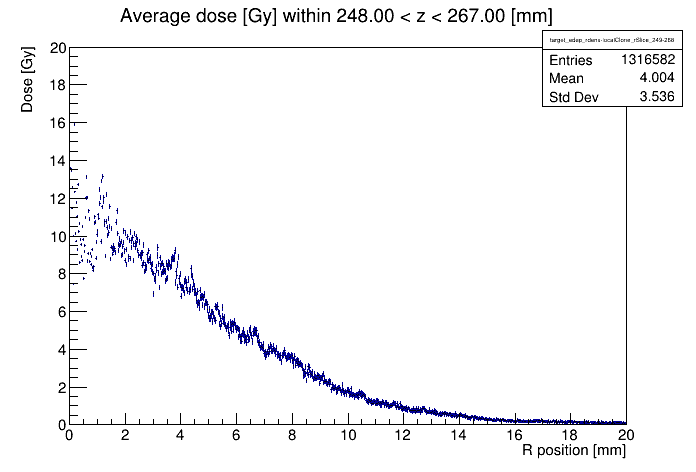

In [37]:
#Plot2, now with a smaller Y range
canvas = ROOT.TCanvas()
rz200[4].GetYaxis().SetRangeUser(0,20)
rz200[4].Draw()
canvas.Draw()

## Testing SingleScatter

TOO SLOW (too much RAM really...). It could be that some cutoffs would help...

In [38]:
baseSimSetup_test200_SS = baseSimSetup.copy()
baseSimSetup_test200_SS["N"] = 50
baseSimSetup_test200_SS["ENERGY"] = 200.0 #[MeV]
baseSimSetup_test200_SS["OUTNAME"]="test_200MeV_SS"
baseSimSetup_test200_SS["PHYS"] = baseSimSetup_test200_SS["PHYS"] + "__SS"

#TRYLOAD = False

#(twiss_test200_SS, numPart_test200_SS, objects_test200_SS) = \
#    miniScatterDriver.getData_tryLoad(baseSimSetup_test200_SS, tryload=TRYLOAD,
#                              getObjects=["targetEdep","target_edep_dens",'target_edep_rdens',"metadata"])

## Testing other physics list

It seems like the list `QGSP_BIC_EMY` should be good.
See:
 * https://indico.lucas.lu.se/event/932/session/0/contribution/35/material/slides/0.pdf
 * https://www.hep.ucl.ac.uk/pbt/wiki/Software/Geant4/Tutorials/Basic/Monoenergetic_Proton_Pencil_Beam
 
The main difference seems to be that we here switch to an EMY EM model; this one is reccomended for "medical, space sci., precise". It is one of the lists reccomended for Bragg curve physics. There is also EMZ which should be even more precise.

In [39]:
baseSimSetup_test200_alt1 = baseSimSetup.copy()
#baseSimSetup_test200_SS["N"] = 50
baseSimSetup_test200_alt1["ENERGY"] = 200.0 #[MeV]
baseSimSetup_test200_alt1["OUTNAME"]="test_200MeV_alt1"
baseSimSetup_test200_alt1["PHYS"] = "QGSP_BIC_EMY"

#baseSimSetup_test200_alt1["EDEP_DZ"] = abs(baseSimSetup_test200_alt1["EDEP_DZ"]) # Make the big 3D histo too

(twiss_test200_alt1, numPart_test200_alt1, objects_test200_alt1) = \
    miniScatterDriver.getData_tryLoad(baseSimSetup_test200_alt1, tryload=TRYLOAD,
                              getObjects=["targetEdep",'target_edep_rdens',"metadata"])

TryLoad is False, computing now.
Running command line: './MiniScatter -t 1000 -m G4_WATER -d 3000.0 -w 1000.0 -p QGSP_BIC_EMY -n 10000 -e 200.0 -b proton -z 0.0 -f test_200MeV_alt1 -o /home/kyrsjo/MiniScatter-work/test_energyScatter/outputs -r --edepDZ -1.0'
RunFolder = '/home/kyrsjo/code/MiniScatter/build'
logName   = '/home/kyrsjo/MiniScatter-work/test_energyScatter/outputs/test_200MeV_alt1.txt'
/
Event# 0
Event# 500
Event# 1000
Event# 1500
Event# 2000
Event# 2500
Event# 3000
Event# 3500
Event# 4000
Event# 4500
Event# 5000
Event# 5500
Event# 6000
Event# 6500
Event# 7000
Event# 7500
Event# 8000
Event# 8500
Event# 9000
Event# 9500
/
Done!
No particles found for det=tracker_cutoff
No particles found for det=target_cutoff


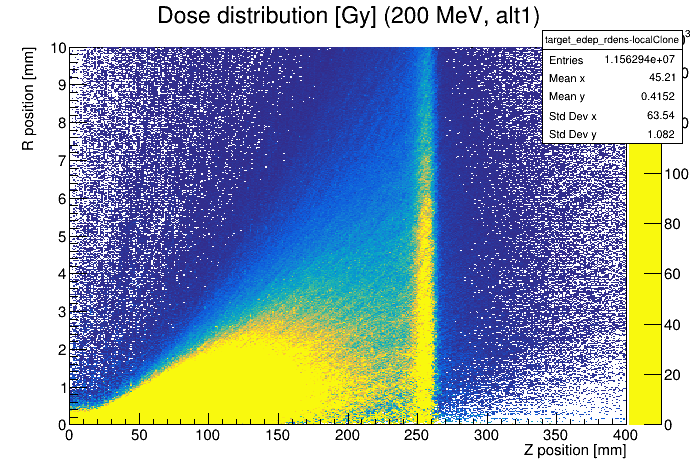

In [40]:
rzScaled_test200_alt1 = miniScatterPlots.plotRZgray(objects_test200_alt1, baseSimSetup_test200_alt1["N"], beamCharge_numpart)
canvas = ROOT.TCanvas()
rzScaled_test200_alt1.SetTitle(rzScaled_test200_alt1.GetTitle() + " (200 MeV, alt1)")
rzScaled_test200_alt1.SetContour(100, np.linspace(0,10,100))
rzScaled_test200_alt1.GetXaxis().SetRangeUser(0,400)
rzScaled_test200_alt1.GetYaxis().SetRangeUser(0,10)
rzScaled_test200_alt1.Draw('colz')
canvas.Draw()

In [41]:
#Test the braggPeakAnalysis function.
# By default it uses an r=10mm integration window
# Plots are in later cells

rz200_alt1 = braggPeakAnalysis(rzScaled_test200_alt1)
#print(rz)
#print()

Avg. dose*L for plateau/peak/after: 387.9, 93.4 13.6 [Gy*mm], proportional to energy deposit in region
Avg. dose for plateau/peak/after:   1.6, 4.4 0.0 [Gy], proportional to -dE/dz


Warning in <TROOT::Append>: Replacing existing TH1: target_edep_rdens-localClone_centralColumn (Potential memory leak).


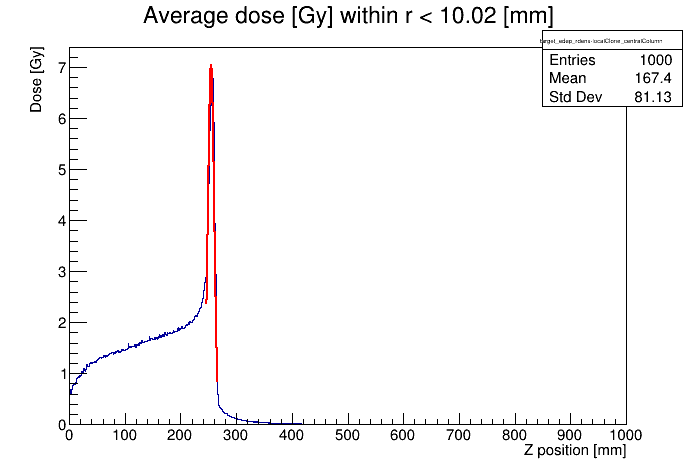

In [42]:
#Plot1
canvas = ROOT.TCanvas()
rz200_alt1[0].Draw()
canvas.Draw()

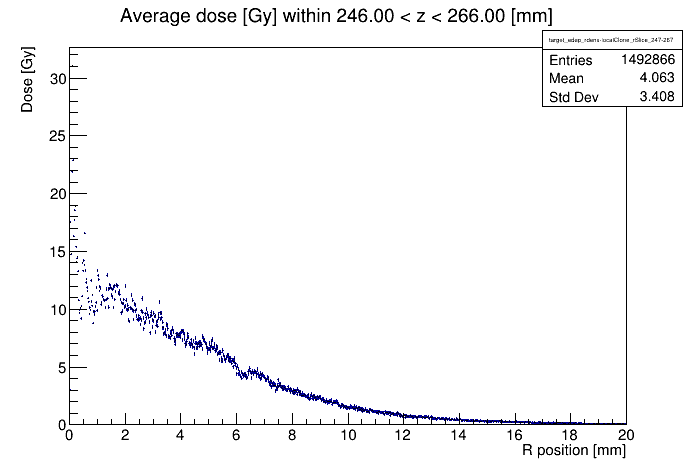

In [43]:
#Plot2
canvas = ROOT.TCanvas()
#rz200[4].GetXaxis().SetRangeUser(0,0.5)
rz200_alt1[4].Draw()
canvas.Draw()

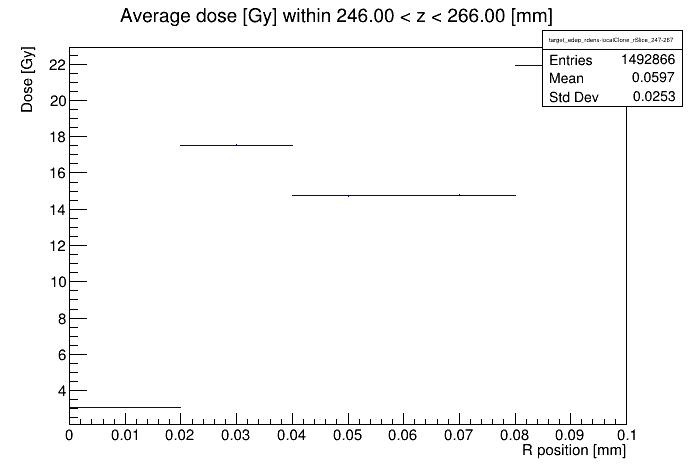

In [44]:
#Plot2, zoomed
canvas = ROOT.TCanvas()
#rz200[4].GetXaxis().SetRangeUser(0,0.5)
rz200_alt1[4].Draw()
rz200_alt1[4].GetXaxis().SetRangeUser(0,0.1)
canvas.Draw()

Note: With this physics list, we have an under-representation in the centermost bin. This is probably due to statistics... But it looks a LOT better!

 FCN=3.10599e+06 FROM MIGRAD    STATUS=CONVERGED      51 CALLS          52 TOTAL
                     EDM=8.30634e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           6.68278e+00   3.09498e-03   2.60490e-03   9.66442e-02
   2  p1           6.39940e+00   5.42496e-03   4.56595e-03  -4.08261e-02


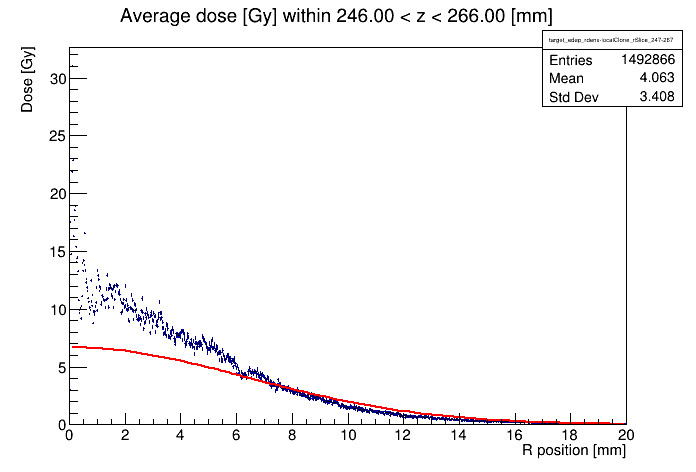

In [45]:
#Fit it with a half gauss in order to find the sigma etc.
canvas = ROOT.TCanvas()
rz200_alt1[4].GetXaxis().SetRangeUser(0,20)
rz200_alt1[4].Draw()
fHG = ROOT.TF1("hGaus","[0]*exp(-0.5*(x/[1])**2)",0,1000)
fHG.SetParameter(0,11)
fHG.SetParameter(1,5)
#fHG.Draw("same")
rz200_alt1[4].Fit("hGaus")
canvas.Draw()

The fit probably fails due to the low outlyer near r=0.

 FCN=490820 FROM MIGRAD    STATUS=CALL LIMIT   1485 CALLS        1486 TOTAL
                     EDM=0.010985    STRATEGY= 1      ERR MATRIX NOT POS-DEF
  EXT PARAMETER                APPROXIMATE        STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.40888e+01   5.87047e-03  -1.42144e-05   3.69188e+01
   2  p1           4.16735e+00   4.23168e-03   1.68540e-04   3.97028e+00
   3  p2          -5.90419e+01   3.43759e+00  -2.98138e-01   6.74731e+00
   4  p3          -5.45837e-03   9.53059e-05   8.29114e-06   2.42547e+05


Warning in <Fit>: Abnormal termination of minimization.


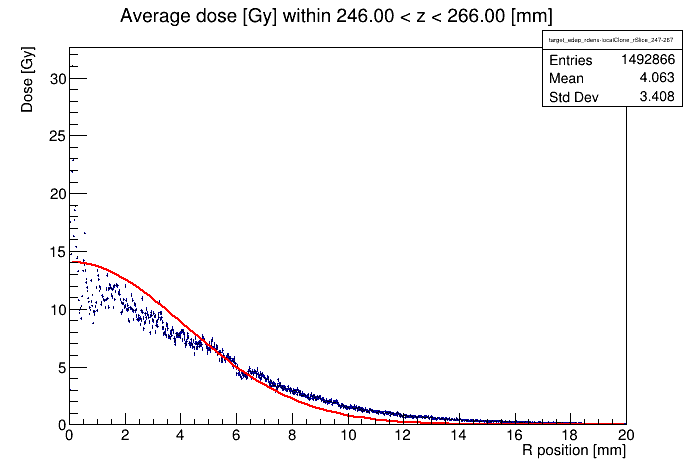

In [46]:
#Fit it with a half gauss in order to find the sigma etc.
canvas = ROOT.TCanvas()
#rz200[4].GetXaxis().SetRangeUser(0,0.5)
rz200_alt1[4].Draw()
fHG2 = ROOT.TF1("hGaus2","[0]*exp(-0.5*(x/[1])**2) + [2]*exp(-0.5*(x/[3])**2)",0,1000)
fHG2.SetParameter(0,20)
fHG2.SetParameter(1,1)
fHG2.SetParameter(2,1)
fHG2.SetParameter(3,10)
rz200_alt1[4].Fit("hGaus2")
canvas.Draw()

A double-gaussian worked pretty well, but the parameters are a bit strange, with one very narrow sigma with negative weight -- this will catch the bad point near r=0. As an example, if we specify the parameters for hGaus, it also fits well (but worse chi2 due to outlier).

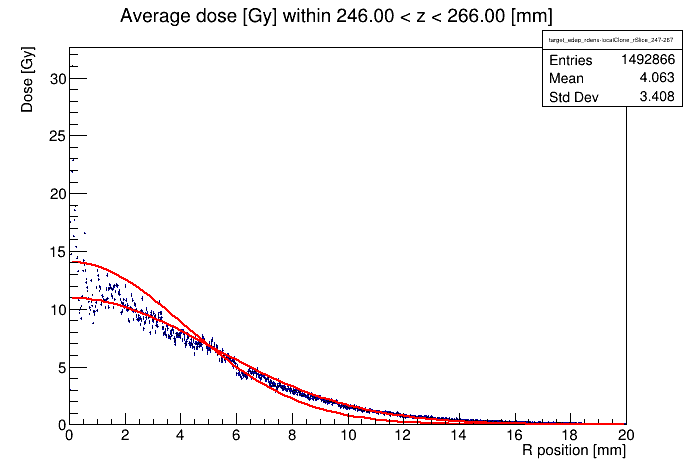

In [47]:
#Fit it with a half gauss in order to find the sigma etc.
canvas = ROOT.TCanvas()
rz200_alt1[4].GetXaxis().SetRangeUser(0,20)
rz200_alt1[4].Draw()
#fHG = ROOT.TF1("hGaus","[0]*exp(-0.5*(x/[1])**2)",0,1000)
fHG.SetParameter(0,10.959)
fHG.SetParameter(1,5.156)
fHG.Draw("same")
#rz200_alt1[4].Fit("hGaus")
canvas.Draw()

Let's do the fit while ignoring the central 1 mm

 FCN=14971.6 FROM MIGRAD    STATUS=CONVERGED      39 CALLS          40 TOTAL
                     EDM=4.84026e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.11659e+01   1.10007e-02   5.26140e-04  -7.18392e-03
   2  p1           4.99590e+00   5.14076e-03   2.45873e-04   5.44500e-03


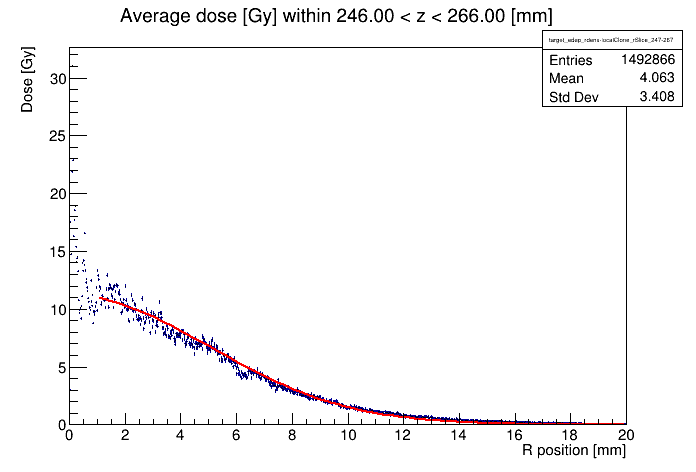

In [48]:
#Fit it with a half gauss in order to find the sigma etc.
canvas = ROOT.TCanvas()
rz200_alt1[4].GetXaxis().SetRangeUser(0,20)
rz200_alt1[4].Draw()
#fHG = ROOT.TF1("hGaus","[0]*exp(-0.5*(x/[1])**2)",0,1000)
fHG.SetParameter(0,10.959)
fHG.SetParameter(1,5.156)
#fHG.Draw("same")
rz200_alt1[4].Fit("hGaus","","",1.0,20.0)
canvas.Draw()

That's pretty good!

# Scanning the energy to extract the Bragg peak position and width

In [49]:
baseSimSetup_scan1 = baseSimSetup.copy()
baseSimSetup_scan1["PHYS"] = "QGSP_BIC_EMY"
baseSimSetup_scan1["N"] = baseSimSetup["N"]
del baseSimSetup_scan1["OUTFOLDER"]

#baseSimSetup_scan1["EDEP_DZ"] = abs(baseSimSetup_scan1["EDEP_DZ"]) # Make the big 3D histo too

scan1_energy = np.arange(50,200,10) #[MeV]
print(scan1_energy)

#TRYLOAD = False

(twiss_scan1, numPart_scan1, objects_scan1, analysis_output_scan1) = \
    miniScatterScanner.ScanMiniScatter("ENERGY",scan1_energy,baseSimSetup_scan1, \
                                       getObjects=["targetEdep",'target_edep_rdens', 'metadata'],\
                                       NUM_THREADS=NUM_THREADS,tryLoad=TRYLOAD,\
                                       COMMENT="scan1_energy", QUIET=True,\
                                       tmpFolder=TMPFOLDER)

# showYield_singleSim(thickScan_Cu,numPart_Cu,baseSimSetup_Cu["N"])
# plt.show()

[ 50  60  70  80  90 100 110 120 130 140 150 160 170 180 190]
LoadFile filename and status: 'SaveSim_ENERGY_scan1_energy.h5' False
ENERGY = 50 (1/15)
ENERGY = 60 (2/15)
ENERGY = 70 (3/15)
ENERGY = 80 (4/15)
ENERGY = 90 (5/15)
ENERGY = 100 (6/15)
ENERGY = 110 (7/15)
ENERGY = 120 (8/15)
ENERGY = 130 (9/15)
ENERGY = 140 (10/15)
WARNING while retrieving object from single-sim ROOT file /tmp/miniScatter/Pthera-EnergyScan/output_ENERGY=50.root: Can't SetName() on object 'metadata'.
ENERGY = 150 (11/15)
WARNING while retrieving object from single-sim ROOT file /tmp/miniScatter/Pthera-EnergyScan/output_ENERGY=60.root: Can't SetName() on object 'metadata'.
ENERGY = 160 (12/15)
WARNING while retrieving object from single-sim ROOT file /tmp/miniScatter/Pthera-EnergyScan/output_ENERGY=70.root: Can't SetName() on object 'metadata'.
ENERGY = 170 (13/15)
WARNING while retrieving object from single-sim ROOT file /tmp/miniScatter/Pthera-EnergyScan/output_ENERGY=80.root: Can't SetName() on object 'metad

Processing 0/15 (50 MeV):
Avg. dose*L for plateau/peak/after: 41.1, 115.8 0.0 [Gy*mm], proportional to energy deposit in region
Avg. dose for plateau/peak/after:   3.2, 10.5 0.0 [Gy], proportional to -dE/dz
Processing 1/15 (60 MeV):
Avg. dose*L for plateau/peak/after: 68.8, 117.1 1.3 [Gy*mm], proportional to energy deposit in region
Avg. dose for plateau/peak/after:   3.1, 10.6 0.0 [Gy], proportional to -dE/dz
Processing 2/15 (70 MeV):
Avg. dose*L for plateau/peak/after: 88.8, 123.9 4.3 [Gy*mm], proportional to energy deposit in region
Avg. dose for plateau/peak/after:   2.9, 10.3 0.0 [Gy], proportional to -dE/dz
Processing 3/15 (80 MeV):
Avg. dose*L for plateau/peak/after: 114.7, 123.1 7.6 [Gy*mm], proportional to energy deposit in region
Avg. dose for plateau/peak/after:   2.7, 10.3 0.0 [Gy], proportional to -dE/dz
Processing 4/15 (90 MeV):
Avg. dose*L for plateau/peak/after: 140.0, 122.7 10.2 [Gy*mm], proportional to energy deposit in region
Avg. dose for plateau/peak/after:   2.6, 

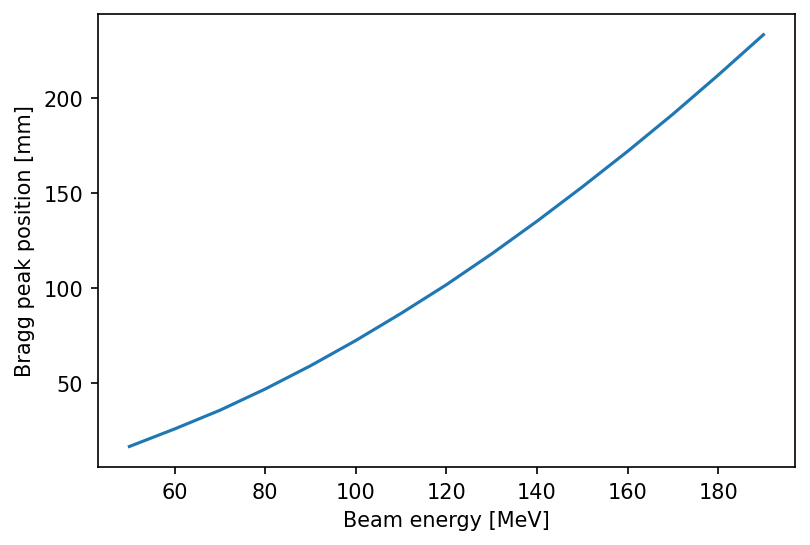

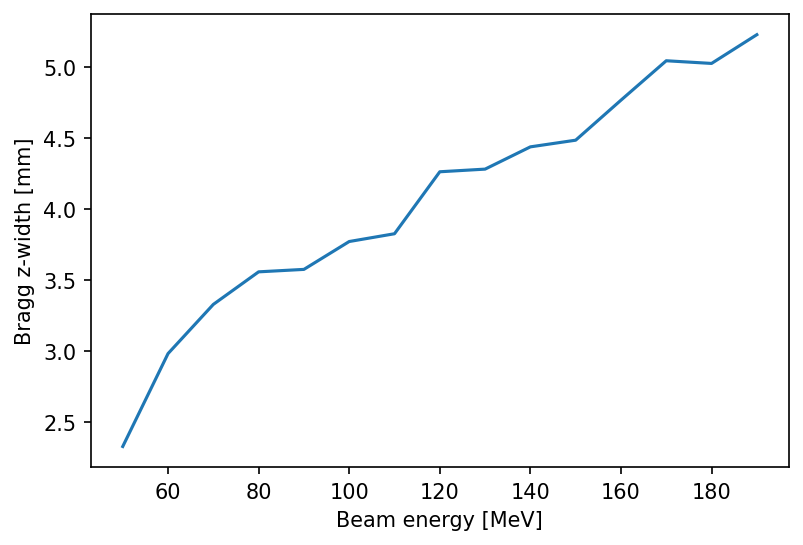

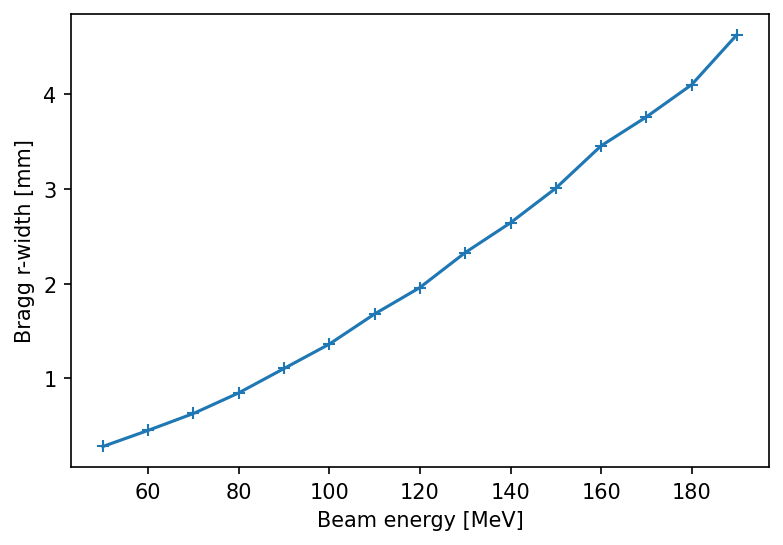

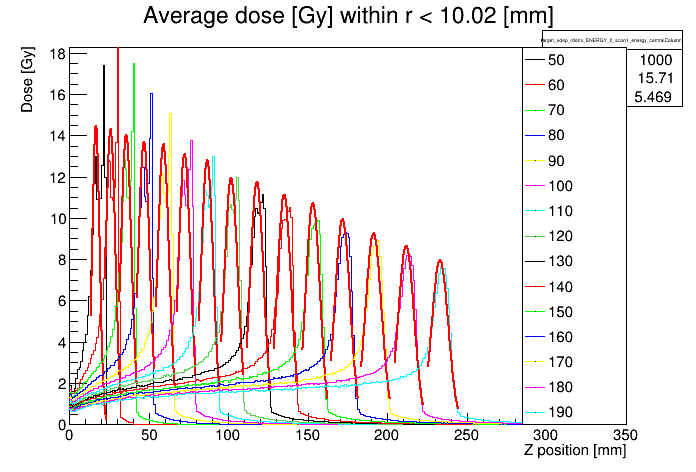

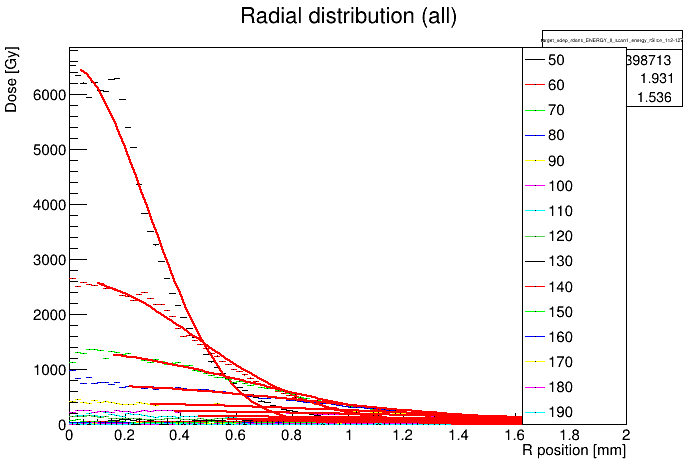

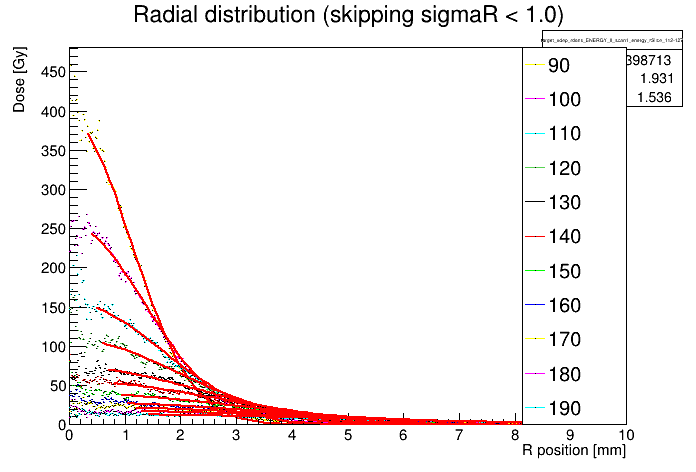

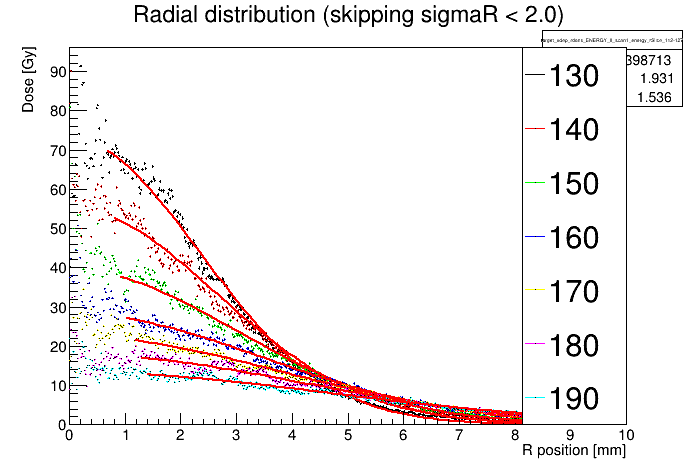

In [50]:
from ROOT import TColor, TLegend

histos_z    = []
histos_r    = []
fits_mean   = []
fits_sigmaz = []
fits_sigmar = []

#reset before first fit
fHG.SetParameter(0,1000)
fHG.SetParameter(1,0.5)
#Previous sigmar, used to estimate the next lower limit
sigmar0 = 0.1

for i in range(len(scan1_energy)):
#for i in range(3):
    print ("Processing {}/{} ({} MeV):".format(i,len(scan1_energy),scan1_energy[i]) )
    objects = {'target_edep_rdens' : objects_scan1['target_edep_rdens'][i], \
               'metadata'          : objects_scan1['metadata'][i]           }
    #print (objects)
    #pdb.set_trace()
    rzScaled = miniScatterPlots.plotRZgray(objects, baseSimSetup_scan1["N"], beamCharge_numpart)
    rz       = braggPeakAnalysis(rzScaled)
    
    #print (rz[3])
    #print (rz[3].Parameter(0), rz[3].Parameter(1), rz[3].Parameter(2)) #Constant, mean, sigma
    fits_mean.append(rz[3].Parameter(1))
    fits_sigmaz.append(rz[3].Parameter(2))
    
    #fHG.SetParameter(1,sigmar0/3.0)
    #rFit = rz[4].Fit("hGaus","SQ","",0.15,10.0)
    rFit = rz[4].Fit("hGaus","SQ","",sigmar0/3.0,10.0)
    fits_sigmar.append(rFit.Parameter(1))
    sigmar0 = rFit.Parameter(1)
    
    histos_r.append(rz[4])
    histos_z.append(rz[0])


plt.figure()
plt.plot(scan1_energy,fits_mean)
plt.ylabel('Bragg peak position [mm]')
plt.xlabel('Beam energy [MeV]')

plt.figure()
plt.plot(scan1_energy,fits_sigmaz)
plt.ylabel('Bragg z-width [mm]')
plt.xlabel('Beam energy [MeV]')

plt.figure()
plt.plot(scan1_energy,fits_sigmar,'-+')
plt.ylabel('Bragg r-width [mm]')
plt.xlabel('Beam energy [MeV]')

plt.show()

canvas_z = ROOT.TCanvas()
legend_z = ROOT.TLegend(0.75,0.1,0.9,0.9);
i = 0
for (e,h) in zip(scan1_energy, histos_z):
    h.SetLineColor((i%8)+1)
    legend_z.AddEntry(h, str(e))
    h.GetXaxis().SetRangeUser(0,350)
    
    if i == 0:
        h.Draw()
    else:
        h.Draw('same')    
    i+=1
legend_z.Draw()
canvas_z.Draw()

canvas_r = ROOT.TCanvas()
legend_r = ROOT.TLegend(0.75,0.1,0.9,0.9);
i = 0
for (e,h) in zip(scan1_energy, histos_r):
    h.SetLineColor((i%8)+1)
    legend_r.AddEntry(h, str(e))
    h.GetXaxis().SetRangeUser(0,2)
    h.SetTitle("Radial distribution (all)")
    
    if i == 0:
        h.Draw()
    else:
        h.Draw('same')    
    i+=1
legend_r.Draw()
canvas_r.Draw()

canvas_r2 = ROOT.TCanvas()
legend_r2 = ROOT.TLegend(0.75,0.1,0.9,0.9);
i = 0
fresh = True
for (e,h) in zip(scan1_energy, histos_r):
    if fits_sigmar[i] < 1.0:
        i+=1
        continue
    fresh = False
    h.SetLineColor((i%8)+1)
    legend_r2.AddEntry(h, str(e))
    h.GetXaxis().SetRangeUser(0,10)
    h.SetTitle("Radial distribution (skipping sigmaR < 1.0)")
    
    if fresh:
        h.Draw()
    else:
        h.Draw('same')    
    i+=1
legend_r2.Draw()
canvas_r2.Draw()

canvas_r3 = ROOT.TCanvas()
legend_r3 = ROOT.TLegend(0.75,0.1,0.9,0.9);
i = 0
fresh = True
for (e,h) in zip(scan1_energy, histos_r):
    if fits_sigmar[i] < 2.0:
        i+=1
        continue
    fresh = False
    h.SetLineColor((i%8)+1)
    legend_r3.AddEntry(h, str(e))
    h.GetXaxis().SetRangeUser(0,10)
    h.SetTitle("Radial distribution (skipping sigmaR < 2.0)")
    
    if fresh:
        h.Draw()
    else:
        h.Draw('same')    
    i+=1
legend_r3.Draw()
canvas_r3.Draw()

Okay, we got what we came for here! Bragg peaks, physics list tests, and scans.

The double/peak structure at low energy is weird. Something to discuss later!